In [19]:
# Type of the task based on the questions.txt
question_category_map = {
    1: "Frequency/Statistics",
    2: "Frequency/Statistics",
    3: "Frequency/Statistics",
    4: "Date range",
    5: "Sentiment",
    6: "Metaphors",
    7: "Metaphors",
    8: "Metaphors",
    9: "Metaphors",
    10: "Frequency/Statistics",
    11: "Sentiment",
    12: "Date range",
    13: "Date range",
    14: "Date range",
    15: "Date range",
    16: "Topic modeling",
    17: "Topic modeling",
    18: "Date range",
    19: "Sentiment",
    20: "Sentiment",
    21: "Sentiment",
    22: "Date range",
    23: "Topic modeling",
    24: "Topic modeling",
    25: "Topic modeling",
    26: "Topic modeling",
    27: "Topic modeling",
    28: "Sentiment",
}

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("all_evaluation.csv", sep=",")
# Type checking
df["answered"] = df["answered"].astype(int)
df["effectiveness"] = pd.to_numeric(df["effectiveness"], errors="coerce")
df["category"] = df["question"].map(question_category_map)
df['group'] = df['group'].str.strip()
df['model'] = df['model'].str.strip()

# for effectivenss (NA -> NaN)
df['effectiveness_raw'] = pd.to_numeric(df['effectiveness'], errors='coerce')
# Normalization (0-1) 
df['effectiveness_norm'] = df['effectiveness_raw'] / 5.0

# Computing Refusal Rate
df['is_refused'] = 1 - df['answered']

df.tail()

,Unnamed: 0,model,k,temperature,question,group,answered,effectiveness,category,effectiveness_raw,effectiveness_norm,is_refused
275,275,phi-4B,10,0.7,24,interpretations,1,4.0,Topic modeling,4.0,0.8,0
276,276,phi-4B,10,0.7,25,interpretations,1,5.0,Topic modeling,5.0,1.0,0
277,277,phi-4B,10,0.7,26,interpretations,1,4.0,Topic modeling,4.0,0.8,0
278,278,phi-4B,10,0.7,27,interpretations,1,5.0,Topic modeling,5.0,1.0,0
279,279,phi-4B,10,0.7,28,interpretations,1,5.0,Sentiment,5.0,1.0,0


=== RAPORT 1: WSZYSTKIE MODELE (W TYM GPT-4o) ===


/var/folders/gg/2dzkwxx92bn382_mjh2vf1nh0000gn/T/ipykernel_71061/755798034.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='is_refused', y='group', data=group_refusal, palette="Reds_r")


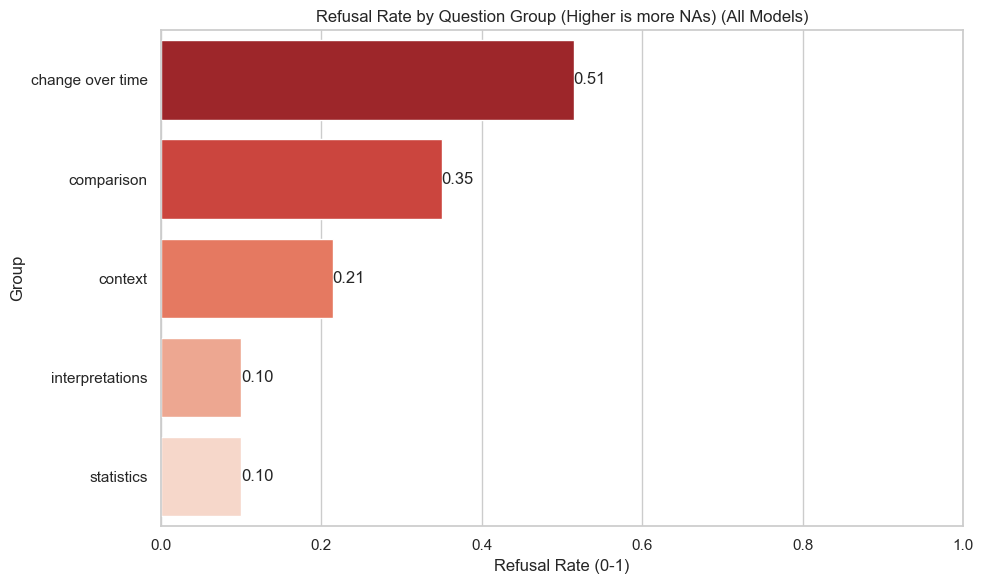

/var/folders/gg/2dzkwxx92bn382_mjh2vf1nh0000gn/T/ipykernel_71061/755798034.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='is_refused', y='model', data=model_refusal, palette="Reds_r")


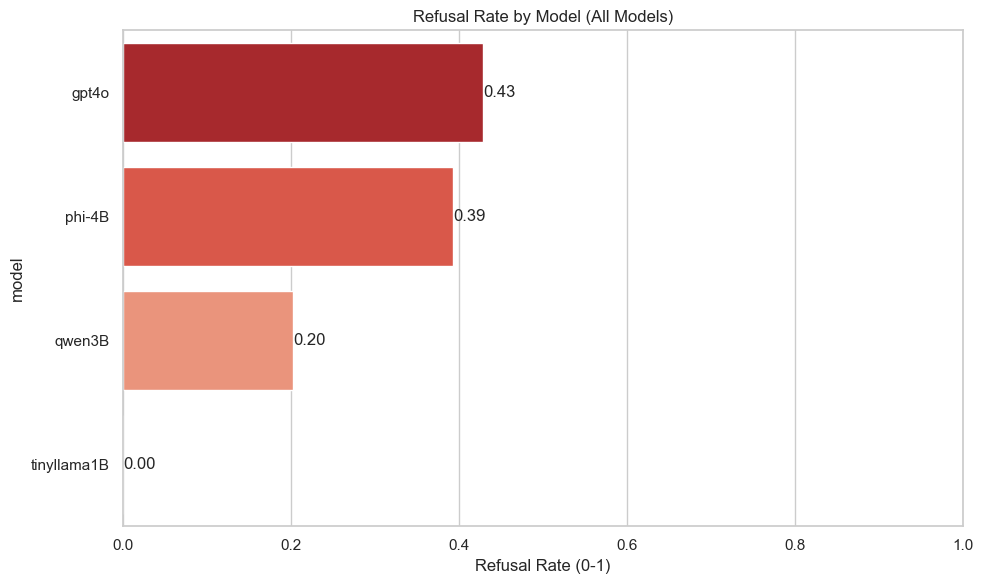

/var/folders/gg/2dzkwxx92bn382_mjh2vf1nh0000gn/T/ipykernel_71061/755798034.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='effectiveness_norm', y='model', data=eff_by_model, palette="Greens_r")


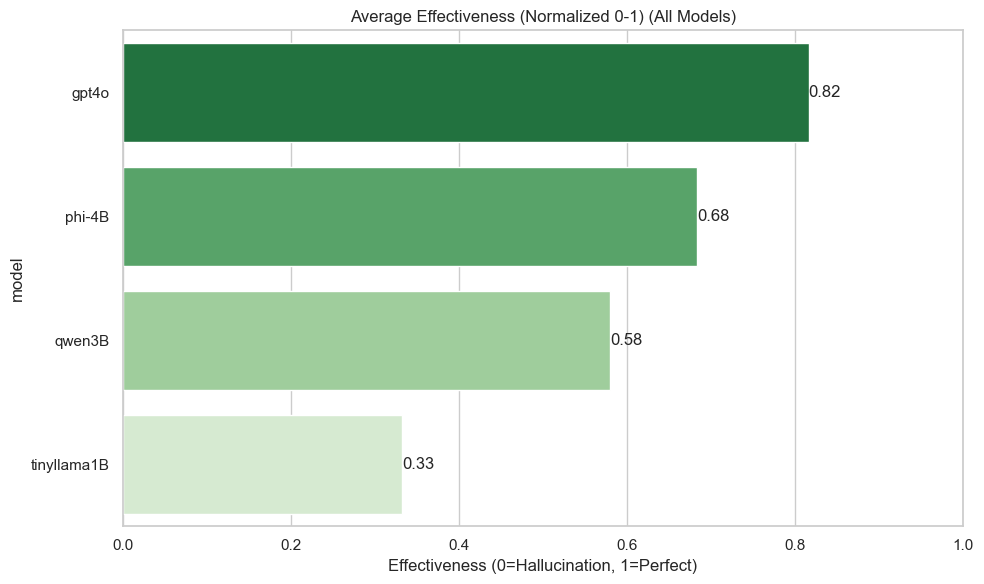

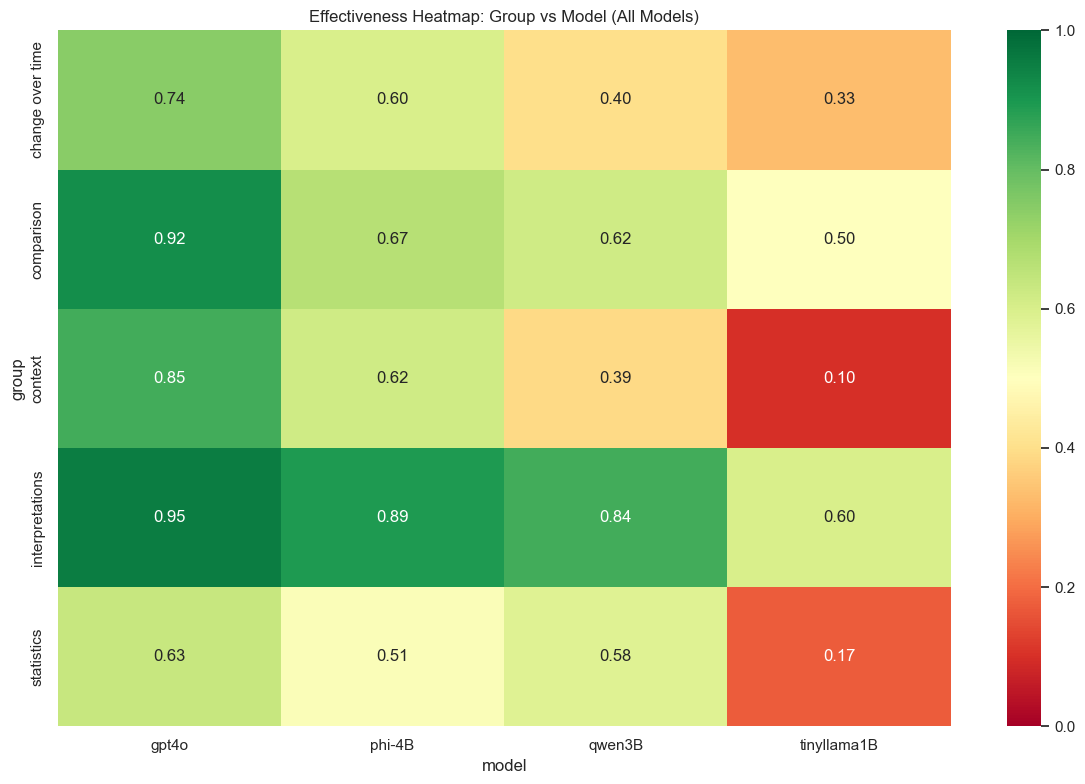

In [32]:
# charts
def generate_dashboard(data, title_suffix=""):
    # Ustawienia stylu
    sns.set_theme(style="whitegrid")
    
    # FIG 1: Refusal Rate by Group (Gdzie najwięcej NA?)
    plt.figure(figsize=(10, 6))
    group_refusal = data.groupby('group')['is_refused'].mean().reset_index()
    # Sortowanie
    group_refusal = group_refusal.sort_values('is_refused', ascending=False)
    
    ax = sns.barplot(x='is_refused', y='group', data=group_refusal, palette="Reds_r")
    plt.title(f'Refusal Rate by Question Group (Higher is more NAs) {title_suffix}')
    plt.xlabel('Refusal Rate (0-1)')
    plt.ylabel('Group')
    plt.xlim(0, 1)
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f')
    plt.tight_layout()
    plt.show()

    # FIG 2: Refusal Rate by Model
    plt.figure(figsize=(10, 6))
    model_refusal = data.groupby('model')['is_refused'].mean().reset_index()
    model_refusal = model_refusal.sort_values('is_refused', ascending=False)
    
    ax = sns.barplot(x='is_refused', y='model', data=model_refusal, palette="Reds_r")
    plt.title(f'Refusal Rate by Model {title_suffix}')
    plt.xlabel('Refusal Rate (0-1)')
    plt.xlim(0, 1)
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f')
    plt.tight_layout()
    plt.show()

    # FIG 3: Normalized Effectiveness by Model
    plt.figure(figsize=(10, 6))
    # Liczymy średnią efektywność tylko dla udzielonych odpowiedzi (dropna automatycznie ignoruje NaN)
    eff_by_model = data.groupby('model')['effectiveness_norm'].mean().reset_index()
    eff_by_model = eff_by_model.sort_values('effectiveness_norm', ascending=False)
    
    ax = sns.barplot(x='effectiveness_norm', y='model', data=eff_by_model, palette="Greens_r")
    plt.title(f'Average Effectiveness (Normalized 0-1) {title_suffix}')
    plt.xlabel('Effectiveness (0=Hallucination, 1=Perfect)')
    plt.xlim(0, 1)
    for i in ax.containers:
        ax.bar_label(i, fmt='%.2f')
    plt.tight_layout()
    plt.show()

    # FIG 4: Effectiveness Heatmap (Group vs Model)
    plt.figure(figsize=(12, 8))
    pivot_eff = data.pivot_table(index='group', columns='model', values='effectiveness_norm', aggfunc='mean')
    sns.heatmap(pivot_eff, annot=True, cmap="RdYlGn", vmin=0, vmax=1, fmt=".2f")
    plt.title(f'Effectiveness Heatmap: Group vs Model {title_suffix}')
    plt.tight_layout()
    plt.show()

# 4. GENEROWANIE RAPORTÓW

print("=== RAPORT 1: WSZYSTKIE MODELE (W TYM GPT-4o) ===")
generate_dashboard(df, "(All Models)")

/var/folders/gg/2dzkwxx92bn382_mjh2vf1nh0000gn/T/ipykernel_71061/4229344787.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='effectiveness_norm', y='config_label', data=eff_config, palette="viridis")


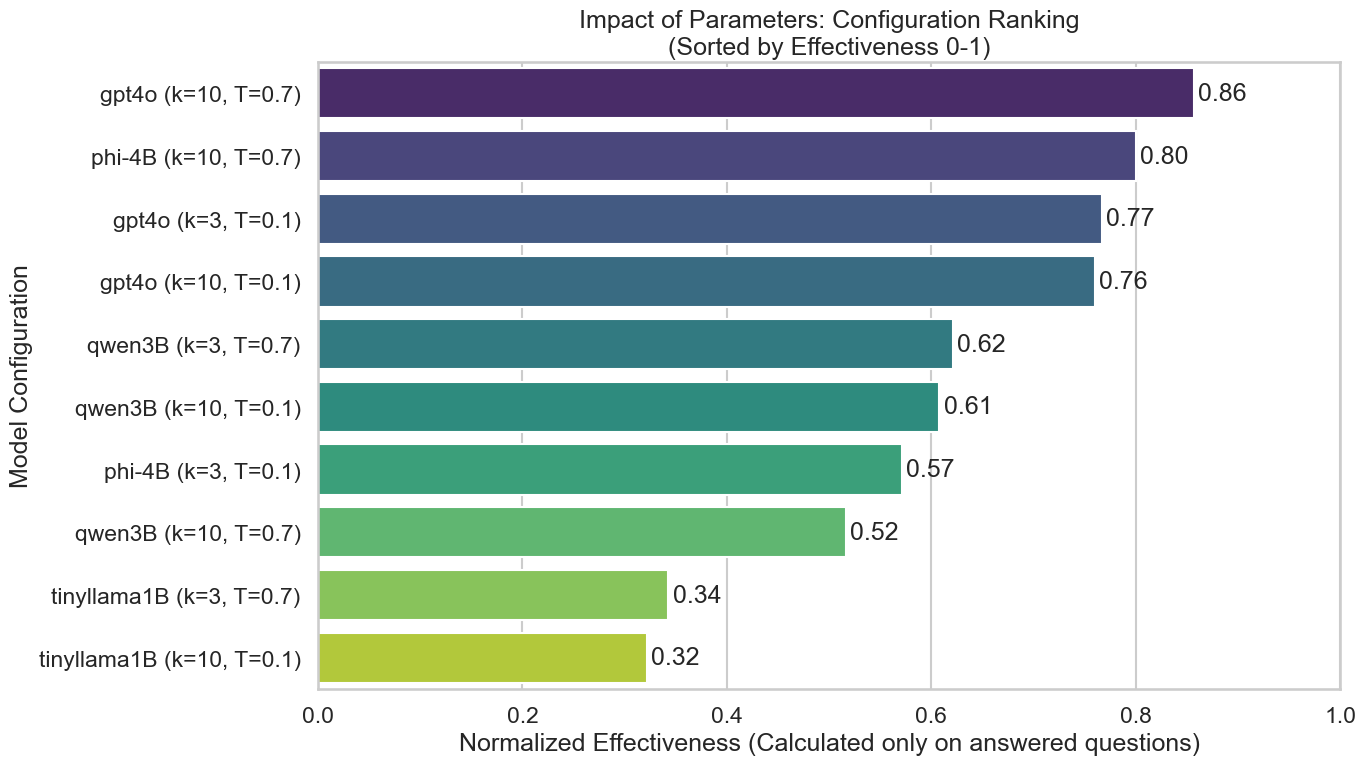

/var/folders/gg/2dzkwxx92bn382_mjh2vf1nh0000gn/T/ipykernel_71061/4229344787.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='effectiveness_norm', y='config', data=eff_config, palette="Blues_r")


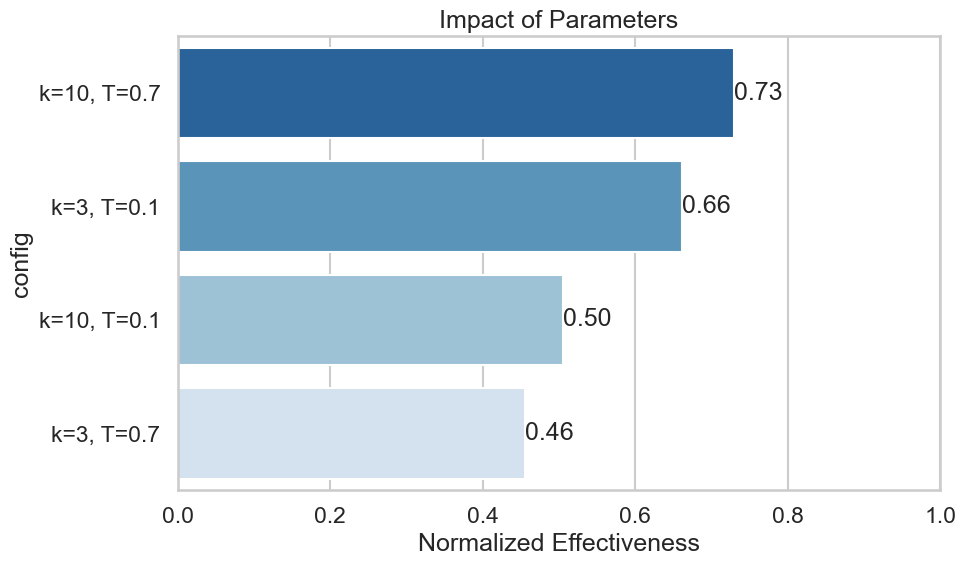

In [29]:
# for params k and T
df['config_label'] = df['model'] + " (k=" + df['k'].astype(str) + ", T=" + df['temperature'].astype(str) + ")"

# style
sns.set_theme(style="whitegrid", context="talk")

# ---------------------------------------------------------
# Chart 1: DETAILED CONFIGURATION RANKING (IMPACT OF PARAMETERS)
# ---------------------------------------------------------
plt.figure(figsize=(14, 8))

eff_config = df.groupby('config_label')['effectiveness_norm'].mean().reset_index()
eff_config = eff_config.sort_values('effectiveness_norm', ascending=False)
ax1 = sns.barplot(x='effectiveness_norm', y='config_label', data=eff_config, palette="viridis")

plt.title('Impact of Parameters: Configuration Ranking\n(Sorted by Effectiveness 0-1)')
plt.xlabel('Normalized Effectiveness (Calculated only on answered questions)')
plt.ylabel('Model Configuration')
plt.xlim(0, 1)

# labels
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Chart 2: AGGREGATED MODEL RANKING
# ---------------------------------------------------------
if 'qwen3B' in df['model'].values:
        
        # config column for params
        df['config'] = "k=" + df['k'].astype(str) + ", T=" + df['temperature'].astype(str)
        
        plt.figure(figsize=(10, 6))
        config_order = sorted(df['config'].unique())
        
        eff_config = df.groupby('config')['effectiveness_norm'].mean().reset_index()
        eff_config = eff_config.sort_values('effectiveness_norm', ascending=False)
        ax = sns.barplot(x='effectiveness_norm', y='config', data=eff_config, palette="Blues_r")
        plt.title(f'Impact of Parameters')
        plt.xlabel('Normalized Effectiveness')
        plt.xlim(0, 1)
        for i in ax.containers:
            ax.bar_label(i, fmt='%.2f')
        plt.tight_layout()
        plt.show()

# How methods differ over categories

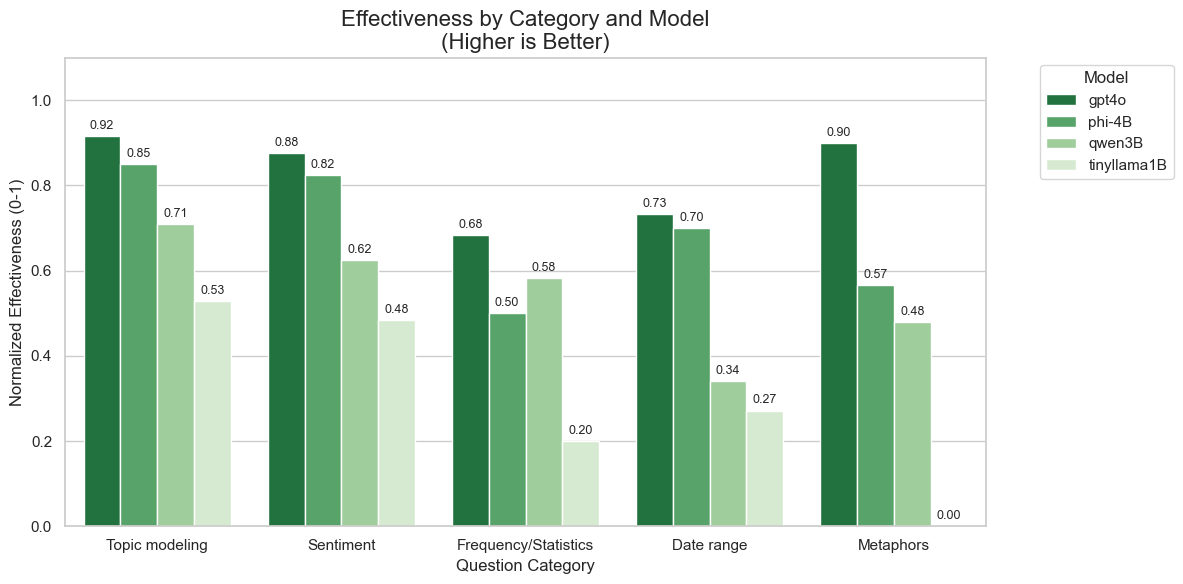

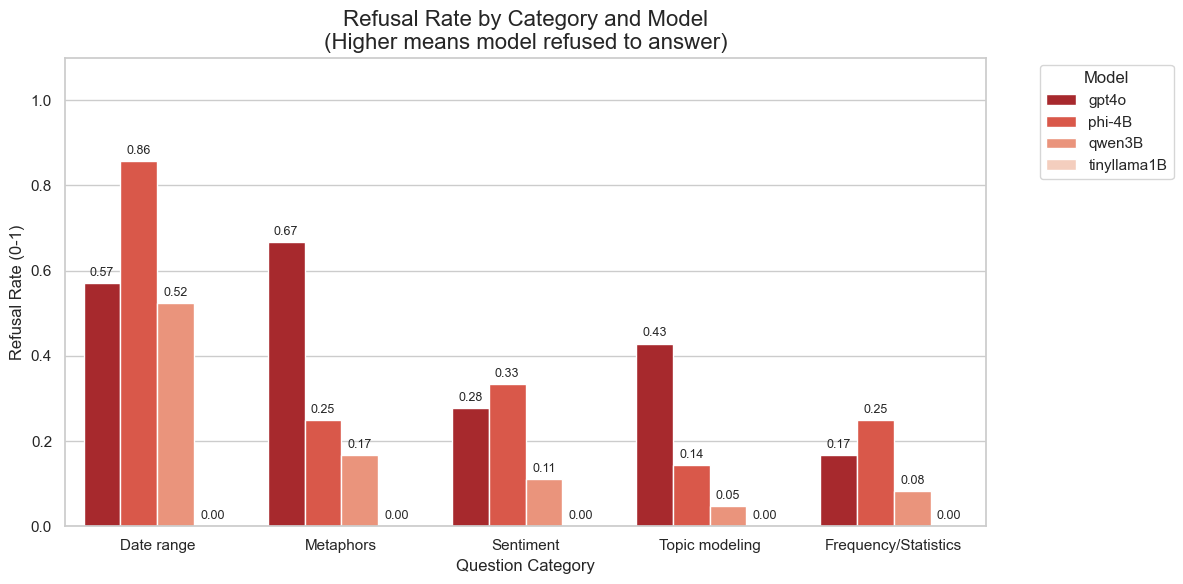

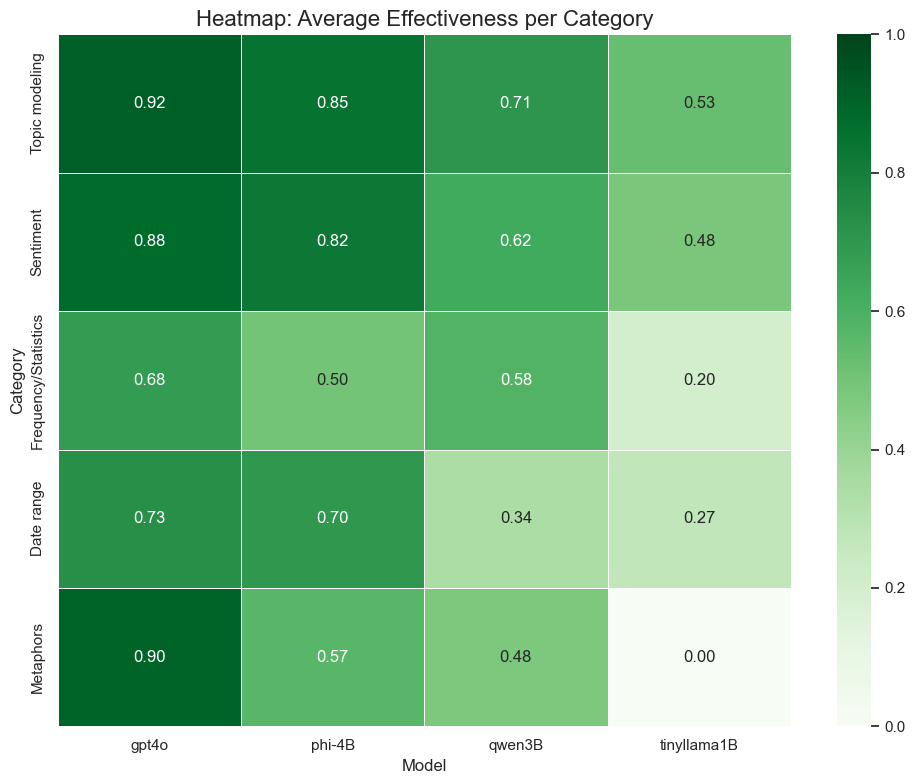

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ustawienie stylu
sns.set_theme(style="whitegrid", context="notebook")

# --- PRZYGOTOWANIE SORTOWANIA ---
# 1. Sortowanie kategorii (Oś X) - od najlepszej do najgorszej średniej
order_cat_eff = df.groupby('category')['effectiveness_norm'].mean().sort_values(ascending=False).index
order_cat_ref = df.groupby('category')['is_refused'].mean().sort_values(ascending=False).index

# 2. Sortowanie modeli (Legend/Słupki) - od najlepszego do najgorszego ogólnie
# To zapewni, że słupki w grupach będą (zazwyczaj) ułożone malejąco
order_model_eff = df.groupby('model')['effectiveness_norm'].mean().sort_values(ascending=False).index
order_model_ref = df.groupby('model')['is_refused'].mean().sort_values(ascending=False).index


# ---------------------------------------------------------
# WYKRES 1: Effectiveness by Category & Model (ZIELONY)
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

ax1 = sns.barplot(
    data=df, 
    x='category', 
    y='effectiveness_norm', 
    hue='model', 
    palette="Greens_r",       # Odcienie zieleni (odwrócone: ciemny -> jasny)
    order=order_cat_eff,      # Sortowanie kategorii malejąco
    hue_order=order_model_eff,# Sortowanie modeli malejąco
    errorbar=None
)

plt.title('Effectiveness by Category and Model\n(Higher is Better)', fontsize=16)
plt.ylabel('Normalized Effectiveness (0-1)')
plt.xlabel('Question Category')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.1)

# Etykiety
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# WYKRES 2: Refusal Rate by Category & Model (CZERWONY)
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

ax2 = sns.barplot(
    data=df, 
    x='category', 
    y='is_refused', 
    hue='model', 
    palette="Reds_r",         # Odcienie czerwieni
    order=order_cat_ref,      # Sortowanie kategorii malejąco (najwięcej odmów po lewej)
    hue_order=order_model_ref,# Sortowanie modeli malejąco
    errorbar=None
)

plt.title('Refusal Rate by Category and Model\n(Higher means model refused to answer)', fontsize=16)
plt.ylabel('Refusal Rate (0-1)')
plt.xlabel('Question Category')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.1)

# Etykiety
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# WYKRES 3: Heatmapa zbiorcza (Effectiveness) - ZIELONA SKALA
# ---------------------------------------------------------
# Pivot table: Wiersze=Kategorie, Kolumny=Modele
pivot_eff = df.pivot_table(
    index='category', 
    columns='model', 
    values='effectiveness_norm', 
    aggfunc='mean'
)

# Sortowanie heatmapy (Wiersze i Kolumny) tak samo jak wykresu słupkowego
pivot_eff = pivot_eff.reindex(index=order_cat_eff, columns=order_model_eff)

plt.figure(figsize=(10, 8))
# Używamy mapy 'Greens' (0=biały, 1=ciemna zieleń)
sns.heatmap(pivot_eff, annot=True, cmap="Greens", vmin=0, vmax=1, fmt=".2f", linewidths=.5)
plt.title('Heatmap: Average Effectiveness per Category', fontsize=16)
plt.ylabel('Category')
plt.xlabel('Model')
plt.tight_layout()
plt.show()